In [1]:
import numpy as np
import pandas as pd
import liionpack as lp
import pybamm as pb

## Solving with liionpack

In [2]:
# getting default parameter values
parameter_vals = pb.ParameterValues("Chen2020")

In [3]:
# changing cell capacity
parameter_vals['Nominal cell capacity [A.h]'] = 60

In [4]:
# getting chemistry dict that can be changed
chemistry = pb.parameter_sets.Chen2020
chemistry

{'chemistry': 'lithium_ion',
 'cell': 'LGM50_Chen2020',
 'negative electrode': 'graphite_Chen2020',
 'separator': 'separator_Chen2020',
 'positive electrode': 'nmc_Chen2020',
 'electrolyte': 'lipf6_Nyman2008',
 'experiment': '1C_discharge_from_full_Chen2020',
 'sei': 'example',
 'citation': 'Chen2020'}

In [5]:
# checking cut-off limits
parameter_vals.search("voltage")

Lower voltage cut-off [V]	2.5
Upper voltage cut-off [V]	4.2


In [6]:
I_init = 90.0 # initial current [A]
V_init = 3.7  # initial battery voltage [V]
Ri_internal = 0.01 # internal resistance [Ω]
R_busbar = 1e-4 # busbar resistance [Ω]
R_connection = 1e-2 # connection resistance [Ω]
R_terminal = 1e-05 # terminal resistance  [Ω]
Np = 36 # number of batteries in series (change to 16/36)
Ns = 2 # number of batteries in parallell (change to 2)
Nbatt = Np * Ns # total number of batteries

#Should commented lines below be executed? 

#parameter_vals['Lower voltage cut-off [V]'] = Ns * parameter_vals['Lower voltage cut-off [V]']
#parameter_vals['Upper voltage cut-off [V]'] = Ns * parameter_vals['Upper voltage cut-off [V]']


In [7]:
parameter_vals.search("connected")
#should these be modified?

Number of cells connected in series to make a battery	1.0
Number of electrodes connected in parallel to make a cell	1.0


In [8]:
# Sets up number of batteries in series and parallel, 
netlist = lp.setup_circuit(Np=Np, Ns=Ns, Ri=Ri_internal, Rc= R_connection, 
                        Rb=R_busbar, Rt=R_terminal, I=I_init, V=V_init, plot=False)

# defines experiment, period states how often data is stored
experiment = pb.Experiment([
    "Charge at 60 A for 30 minutes",
    "Discharge at 60 A for 30 minutes"
    
],
period = "10 seconds")

In [9]:
# variables returned to our solver
output_variables = [
    "Current [A]"
]
# 
output = lp.solve(
    netlist = netlist,
    parameter_values = parameter_vals,
    experiment = experiment,
    output_variables = output_variables,
    initial_soc = 0.0685
)

Stepping simulation: 100%|██████████| 361/361 [00:07<00:00, 51.06it/s]


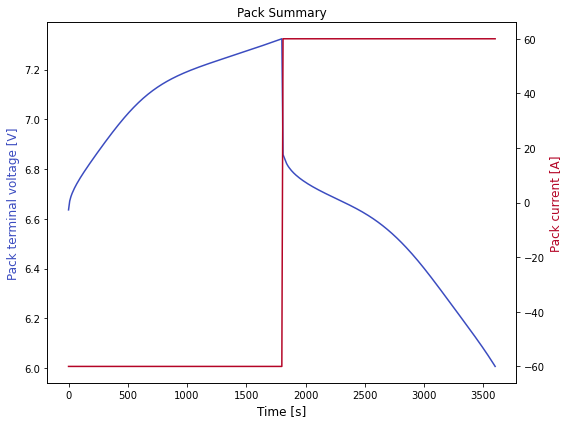

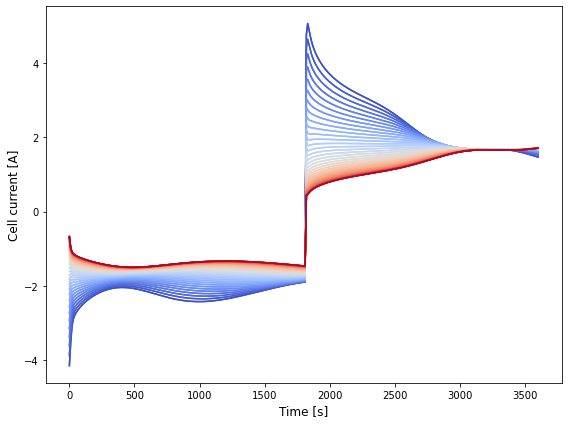

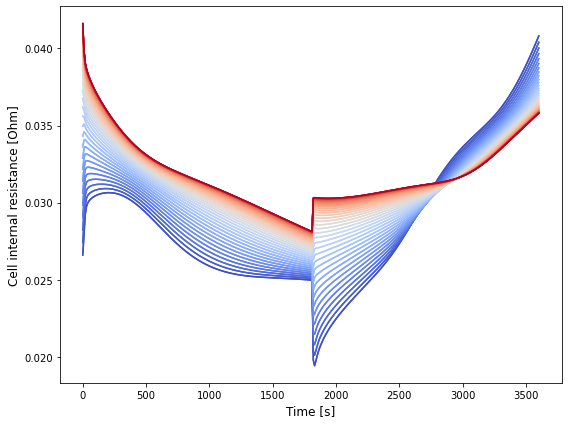

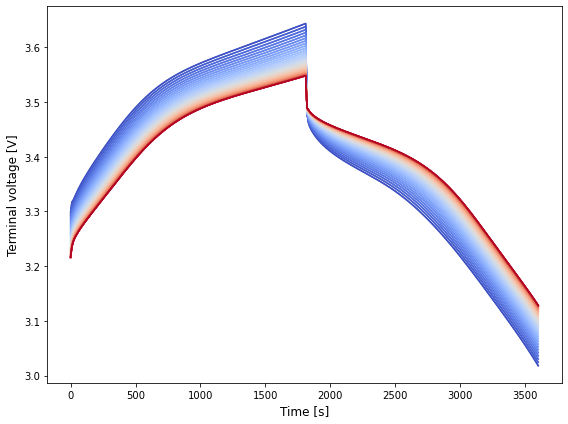

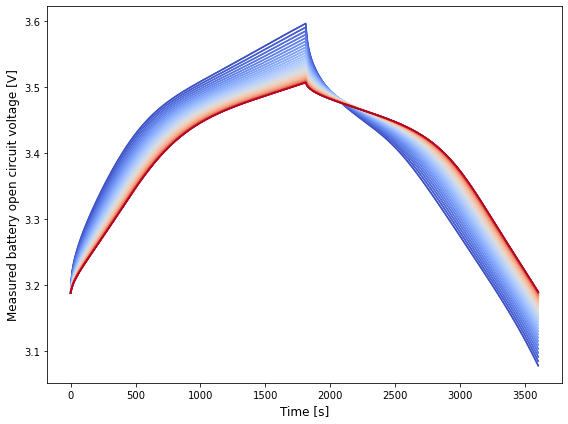

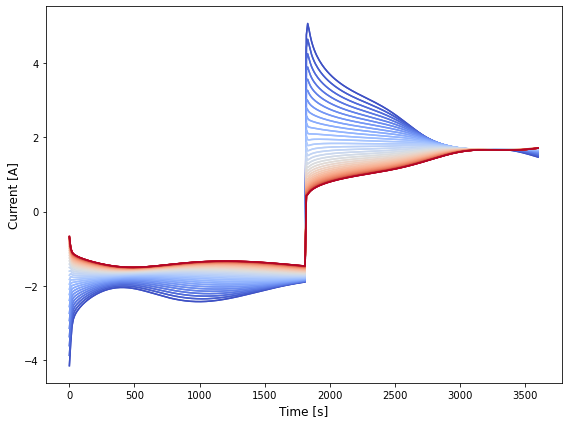

In [10]:
lp.plot_output(output)

In [46]:
df = pd.DataFrame.from_dict(data = output, orient = 'index').T
df.head(3)

,Time [s],Pack current [A],Pack terminal voltage [V],Cell current [A],Cell internal resistance [Ohm],Terminal voltage [V],Measured battery open circuit voltage [V],Current [A]
0,0.0,-60.0,6.635721,"[-4.013452646160698, -4.013452646160675, -3.80...","[0.026993588923236174, 0.026993588923236327, 0...","[3.2962340654183198, 3.2962340654183198, 3.292...","[3.1878965745249834, 3.1878965745249834, 3.187...","[-4.013452646160698, -4.013452646160675, -3.80..."
1,10.0,-60.0,6.67171,"[-3.496934431947612, -3.4969344319475884, -3.2...","[0.028080390219202233, 0.028080390219202295, 0...","[3.3160590714976808, 3.3160590714976803, 3.310...","[3.2178637880776275, 3.2178637880776275, 3.216...","[-3.496934431947612, -3.4969344319475884, -3.2..."
2,20.0,-60.0,6.689207,"[-3.082725027045163, -3.082725027045163, -2.92...","[0.029271509235949515, 0.029271509235949515, 0...","[3.3202134356070343, 3.3202134356070365, 3.315...","[3.229977421505989, 3.2299774215059913, 3.2277...","[-3.082725027045163, -3.082725027045163, -2.92..."


In [47]:
#df = pd.DataFrame.from_dict(data = output, orient = 'index').T
for column in list(df.columns):
    
    if df[column][0].size > 1:
        s = column.split(" ")
        if s[0] == "Cell":
            print(column)
            #L = ["#" + str(i) + " " + str(column) for i in range(df[column][0].size)]
            #print(L)
            df[["#" + str(i) + " " + str(column) for i in range(df[column][0].size)]] = pd.DataFrame(df[str(column)].tolist(), index = df.index)
            df = df.drop(columns=[column], axis=1)
                
        else:
            #G = ["#" + str(i) + " Cell " + str(column) for i in range(df[column][0].size)]
            df[["#" + str(i) + " Cell " + str(column) for i in range(df[column][0].size)]] = pd.DataFrame(df[str(column)].tolist(), index = df.index)
            df = df.drop(columns=[column], axis = 1)
        
    else:
        continue

df.head()

Cell current [A]
Cell internal resistance [Ohm]


,Time [s],Pack current [A],Pack terminal voltage [V],#0 Cell current [A],#1 Cell current [A],#2 Cell current [A],#3 Cell current [A],#4 Cell current [A],#5 Cell current [A],#6 Cell current [A],...,#62 Cell Current [A],#63 Cell Current [A],#64 Cell Current [A],#65 Cell Current [A],#66 Cell Current [A],#67 Cell Current [A],#68 Cell Current [A],#69 Cell Current [A],#70 Cell Current [A],#71 Cell Current [A]
0,0.0,-60.0,6.635721,-4.013453,-4.013453,-3.800276,-3.800276,-3.594248,-3.594248,-3.395484,...,-0.589026,-0.589026,-0.570404,-0.570404,-0.556470,-0.556470,-0.547272,-0.547272,-0.542638,-0.542638
1,10.0,-60.0,6.67171,-3.496934,-3.496934,-3.287687,-3.287687,-3.092898,-3.092898,-2.911659,...,-0.980944,-0.980944,-0.972141,-0.972141,-0.965592,-0.965592,-0.961256,-0.961256,-0.959093,-0.959093
2,20.0,-60.0,6.689207,-3.082725,-3.082725,-2.923945,-2.923945,-2.776169,-2.776169,-2.638711,...,-1.109507,-1.109507,-1.101201,-1.101201,-1.095011,-1.095011,-1.090885,-1.090885,-1.088826,-1.088826
3,30.0,-60.0,6.702264,-2.903534,-2.903534,-2.772050,-2.772050,-2.648727,-2.648727,-2.533130,...,-1.154133,-1.154133,-1.146006,-1.146006,-1.139927,-1.139927,-1.135886,-1.135886,-1.133868,-1.133868
4,40.0,-60.0,6.713388,-2.804796,-2.804796,-2.688293,-2.688293,-2.578305,-2.578305,-2.474512,...,-1.181663,-1.181663,-1.173783,-1.173783,-1.167888,-1.167888,-1.163968,-1.163968,-1.162011,-1.162011


In [52]:
def to_dataframe(df):
    """
    Turns output into datadrame containing data for pack and cells
    Input: dictionary containing pack- and cell data
    Returns: data frame of data from solver
    """
    df = pd.DataFrame.from_dict(data = output, orient = 'index').T
    
    for column in list(df.columns):
        if df[column][0].size > 1:
            s = column.split(" ")
            if s[0] == "Cell":
                df[["#" + str(i) + " " + str(column) for i in range(df[column][0].size)]] = pd.DataFrame(df[str(column)].tolist(), index = df.index)
                df = df.drop(columns=[column], axis = 1)
                
                
            else:
                df[["#" + str(i) + " Cell " + str(column) for i in range(df[column][0].size)]] = pd.DataFrame(df[str(column)].tolist(), index = df.index)
                print("Column to be dropped: " + column)
                df = df.drop(columns=[column], axis = 1)
        
        else:
            continue
    return df
   
output = lp.solve(
    netlist = netlist,
    parameter_values = parameter_vals,
    experiment = experiment,
    output_variables = output_variables,
    initial_soc = 0.0685
)
output = to_dataframe(output)
output.head()
        

Stepping simulation: 100%|██████████| 361/361 [00:10<00:00, 35.12it/s]


Column to be dropped: Terminal voltage [V]
Column to be dropped: Measured battery open circuit voltage [V]
Column to be dropped: Current [A]


,Time [s],Pack current [A],Pack terminal voltage [V],#0 Cell current [A],#1 Cell current [A],#2 Cell current [A],#3 Cell current [A],#4 Cell current [A],#5 Cell current [A],#6 Cell current [A],...,#62 Cell Current [A],#63 Cell Current [A],#64 Cell Current [A],#65 Cell Current [A],#66 Cell Current [A],#67 Cell Current [A],#68 Cell Current [A],#69 Cell Current [A],#70 Cell Current [A],#71 Cell Current [A]
0,0.0,-60.0,6.645977,-2.031375,-2.031375,-2.019237,-2.019237,-2.005396,-2.005396,-1.989657,...,-1.413109,-1.413109,-1.407338,-1.407338,-1.403012,-1.403012,-1.400129,-1.400129,-1.398688,-1.398688
1,10.0,-60.0,6.672334,-3.016792,-3.016792,-2.885110,-2.885110,-2.759706,-2.759706,-2.640279,...,-1.077150,-1.077150,-1.067588,-1.067588,-1.060442,-1.060442,-1.055690,-1.055690,-1.053318,-1.053318
2,20.0,-60.0,6.688727,-3.058699,-3.058699,-2.906057,-2.906057,-2.763555,-2.763555,-2.630521,...,-1.109102,-1.109102,-1.100728,-1.100728,-1.094473,-1.094473,-1.090317,-1.090317,-1.088242,-1.088242
3,30.0,-60.0,6.701814,-2.947182,-2.947182,-2.807399,-2.807399,-2.677012,-2.677012,-2.555254,...,-1.147851,-1.147851,-1.139848,-1.139848,-1.133868,-1.133868,-1.129892,-1.129892,-1.127906,-1.127906
4,40.0,-60.0,6.713039,-2.844921,-2.844921,-2.720326,-2.720326,-2.603428,-2.603428,-2.493705,...,-1.176619,-1.176619,-1.168842,-1.168842,-1.163029,-1.163029,-1.159162,-1.159162,-1.157231,-1.157231


In [ ]:
def to_DF_mean(output):
    """
    Turns output of lp.solver into dataframe of mean values
    Input: output of lp.solver(output) - dictionary
    Returns: DataFrame of solver & its mean values
    """
    output = pd.DataFrame.from_dict(data = output, orient = 'index')
    
    for i in range(len(output.columns)):
        output.loc['Cell current [A]', i] = output.loc['Cell current [A]',i].mean()
        output.loc['Cell internal resistance [Ohm]', i] = output.loc['Cell internal resistance [Ohm]',i].mean()
        output.loc['Terminal voltage [V]', i] = output.loc['Terminal voltage [V]',i].mean()
        output.loc['Measured battery open circuit voltage [V]', i] = output.loc['Measured battery open circuit voltage [V]'].mean()
        output.loc['Measured battery open circuit voltage [V]', i] = output.loc['Measured battery open circuit voltage [V]',i].mean()
    
    return output.T

output = to_DF_mean(output)
output = output.drop(columns = ['Current [A]'], axis = 1)
output.head()


## Theo's experiment

In [ ]:
import os
abs_path = os.path.abspath(os.path.dirname('theo_cycle.csv'))
print(abs_path)
test_cycle = pd.read_csv("/Users/eirikbaekkelund/Desktop/RePack/EIR_Related/Python/liionpack/Testing PyBaMM/theo_cycle.csv")

In [ ]:
test_cycle.tail()


In [ ]:
test_cycle = test_cycle.astype({'Uptime' : 'string'})

test_cycle['Uptime'] = test_cycle['Uptime'].str.split('d').str.get(1)
test_cycle = test_cycle.drop(['Connection', 'Status', 'IO State'], axis = 1)
test_cycle.tail()

## Solving with PyBaMM
*Note that this will assume every cell in the pack is **identical**.*

In [ ]:
parameter_values = pb.ParameterValues("Chen2020")
parameter_values.update({"Nominal cell capacity [A.h]": "[input]",
                        "Typical current [A]": "[input]",
                        "Current function [A]": "[input]",
                        "Number of cells connected in series to make a battery": 16,
                        "Number of electrodes connected in parallel to make a cell": 2})

capacity = np.array([1.0 for i in range(Np*Ns)]) * 57.0



SPMe = pb.lithium_ion.SPMe()
param = SPMe.param

Vmin = 1.2  
Vmax = 5.0  

neg_conc = parameter_values.evaluate(param.C_n_init)
pos_conc = parameter_values.evaluate(param.C_p_init)

Li_init = parameter_values.evaluate(param.n_Li_particles_init)

inputs = {"V_min": Vmin, 
          "V_max": Vmax,
          "C_n": neg_conc,
          "C_p": pos_conc, 
          "n_Li": Li_init,
         }

experiment = pb.Experiment([
    "Charge at 5 A for 30 minutes",
    "Discharge at 5 A for 30 minutes"
    
],
period = "10 seconds")






In [ ]:
sim = pb.Simulation(
    model = SPMe,
    experiment=experiment,
    parameter_values= parameter_values,
)
sol = sim.solve(initial_soc=0.0685)


sol = sim.solve([0,360],
                inputs = {"V_min": Vmin,"V_max": Vmax,"C_n": neg_conc,"C_p": pos_conc, "n_Li": Li_init,
                })

In [ ]:
print(f"Initial negative electrode SOC: {sol['x_100'].data[0]:.3f}")
print(f"Initial positive electrode SOC: {sol['y_100'].data[0]:.3f}")

c_n_max = parameter_values.evaluate(param.c_n_max) 
c_p_max = parameter_values.evaluate(param.c_p_max) 

parameter_values.update({
        "Initial concentration in negative electrode [mol.m-3]": sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": sol["y_100"].data[0] * c_p_max,
})